In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
df1 = pd.read_csv('storage/pdb/pdb_data_no_dups.csv')
df2 = pd.read_csv('storage/pdb/pdb_data_seq.csv')

df = pd.merge(df1,df2[['structureId','chainId','sequence']], on='structureId', how='inner')
df.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


Total number of protein classes

In [3]:
df = df[df['macromoleculeType'] == "Protein"]
print(df.shape)
len(df[df['macromoleculeType'] == "Protein"]['classification'].value_counts())

(110228, 16)


2706

Missing values per column in percentage

In [4]:

for i, v in df.isnull().sum().items():
    print(i, " : ", round((v/471149)*100, 1))

structureId  :  0.0
classification  :  0.0
experimentalTechnique  :  0.0
macromoleculeType  :  0.0
residueCount  :  0.0
resolution  :  2.6
structureMolecularWeight  :  0.0
crystallizationMethod  :  10.9
crystallizationTempK  :  10.8
densityMatthews  :  3.1
densityPercentSol  :  3.1
pdbxDetails  :  5.1
phValue  :  6.1
publicationYear  :  2.7
chainId  :  0.0
sequence  :  0.0


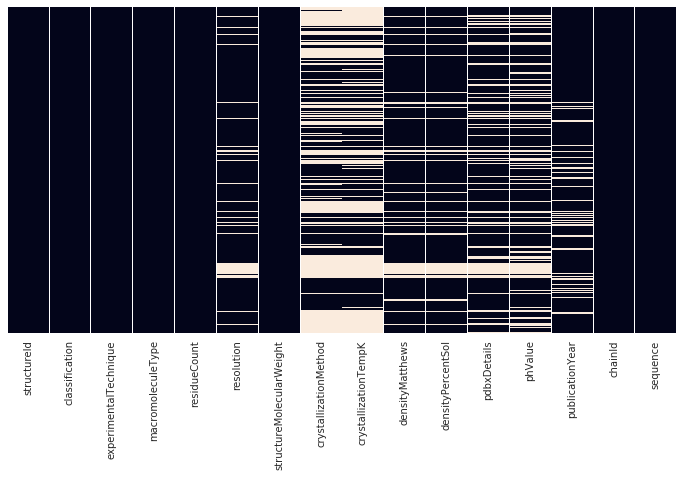

In [5]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), yticklabels=False,cbar=False)
plt.show()

In [6]:
df['classification'] = df['classification'].astype('str')
df = df[df['macromoleculeType'] == "Protein"]
df.reset_index(inplace=True, drop=True)

df['classification'] = df['classification'].str.lower()
df['classification'] = df['classification'].str.replace('(', '/')
df['classification'] = df['classification'].str.replace(',', '/')
df['classification'] = df['classification'].str.replace(', ', '/')
df['classification'] = df['classification'].str.replace('/ ', '/')
df['classification'] = df['classification'].str.replace(')', '')
# pattern = '|'.join([', ', ',', '('])
# df['classification'] = df['classification'].str.replace(pattern, '/')

# Maintaing class ordering. There are the same classes with different order 
#ex. viral protein/immune system and immune system/viral protein
df['classification'] = df['classification'].apply(lambda x:"/".join(sorted(x.split('/'))))

df.head(3)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,101M,oxygen transport,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,hydrolase/o-glycosyl,X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,oxygen transport,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


Deleting outliar 23 values for <b>Molecular weight</b> which was for Virus classification. It was a very small number so was deleted.

<b> Note: </b> Molecular weight is calculated using sequence using the weight of each amino acid. Thus, if sequence is long, then it can have large weight


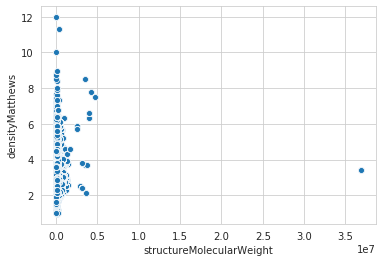

In [7]:
sns.scatterplot(x="structureMolecularWeight", y="densityMatthews", data=df)

# Later check: You can compare weight with sequence length

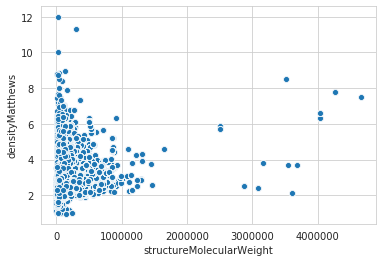

In [8]:
#density_weight = df[['classification','densityMatthews','structureMolecularWeight']].dropna().copy()
weight_max = df['structureMolecularWeight'] == df['structureMolecularWeight'].max()
df = df[~weight_max].copy()
sns.scatterplot(x="structureMolecularWeight", y="densityMatthews", data=df)

Dealing with outliar of phValue. 

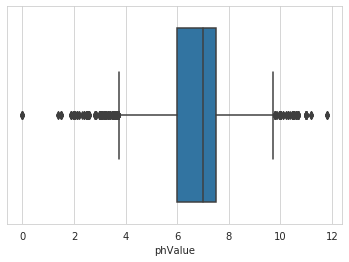

In [9]:
df['phValue'] = df['phValue'].replace(100, np.nan)
sns.boxplot(df['phValue'].dropna())

In [10]:
df.phValue.isnull().sum()

28751

In [11]:
df.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence'],
      dtype='object')

In [12]:
df.drop(['crystallizationMethod','crystallizationTempK', 'publicationYear', 'pdbxDetails'], axis=1, inplace=True) 
df.dropna(subset=['densityMatthews','densityPercentSol','resolution', 'sequence'], inplace=True)

Filter dataset's records for classification types which are > 100

In [13]:
counts = df['classification'].value_counts()

types = np.asarray(counts[(counts > 100)].index)

data = df[df.classification.isin(types)].copy()
data.head(3)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue,chainId,sequence
0,101M,oxygen transport,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,3.09,60.20,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,hydrolase/o-glycosyl,X-RAY DIFFRACTION,Protein,165,1.74,18926.61,2.75,55.28,NaN,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,oxygen transport,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,3.09,60.20,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [14]:
data.phValue.isnull().sum()

10667

Handling Outliar of PhValue

In [15]:
class_dict = dict()
count = 0

classes = data['classification'].value_counts().items()

for cat, num in classes:
    
    # Remove all other classes that have number of values are less than 100
    if num < 100:
        temp = data['classification'] == cat
        data = data[~temp].copy()
        continue
        
    # Remove all a class if all phValues are null
    if data[(data['classification'] == cat) & (data['phValue'].notnull())].phValue.count() == 0:
        temp = data['classification'] == cat
        data = data[~temp].copy()
        continue
    
    ph_mean = round(data[data['classification'] == cat]['phValue'].dropna().mean(),2)
    data.loc[(data['classification'] == cat) & (data['phValue'].isna()),'phValue'] = ph_mean
    
    
    
    if num >= 100:
        class_dict[cat] = count
        count += 1

class_dict

{'hydrolase': 0,
 'transferase': 1,
 'oxidoreductase': 2,
 'lyase': 3,
 'immune system': 4,
 'structural genomics/unknown function': 5,
 'hydrolase/hydrolase inhibitor': 6,
 'transcription': 7,
 'isomerase': 8,
 'signaling protein': 9,
 'ligase': 10,
 'transport protein': 11,
 'electron transport': 12,
 'viral protein': 13,
 'sugar binding protein': 14,
 'membrane protein': 15,
 'chaperone': 16,
 'toxin': 17,
 'dna binding protein': 18,
 'structural protein': 19,
 'metal binding protein': 20,
 'unknown function': 21,
 'oxygen storage/transport': 22,
 'protein binding': 23,
 'photosynthesis': 24,
 'cell adhesion': 25,
 'protein transport': 26,
 'growth factor/hormone': 27,
 'cell cycle': 28,
 'oxygen transport': 29,
 'metal transport': 30,
 'lectin': 31,
 'blood clotting': 32,
 'hormone': 33,
 'immunoglobulin': 34,
 'rna binding protein': 35,
 'biosynthetic protein': 36,
 'luminescent protein': 37,
 'gene regulation': 38,
 'translation': 39,
 'apoptosis': 40,
 'virus': 41,
 'cytokine': 

In [16]:
data['class'] = data['classification'].map(class_dict)
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue,chainId,sequence,class
0,101M,oxygen transport,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,3.09,60.2,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,29
2,102M,oxygen transport,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,3.09,60.2,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,29
4,103M,oxygen transport,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,3.09,60.3,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,29
7,104M,oxygen transport,X-RAY DIFFRACTION,Protein,153,1.71,18030.63,1.87,34.3,7.0,A,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,29
8,105M,oxygen transport,X-RAY DIFFRACTION,Protein,153,2.02,18030.63,1.83,33.0,9.0,A,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,29


In [17]:
data.isnull().sum()

structureId                 0
classification              0
experimentalTechnique       0
macromoleculeType           0
residueCount                0
resolution                  0
structureMolecularWeight    0
densityMatthews             0
densityPercentSol           0
phValue                     0
chainId                     0
sequence                    0
class                       0
dtype: int64

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80659 entries, 0 to 110227
Data columns (total 13 columns):
structureId                 80659 non-null object
classification              80659 non-null object
experimentalTechnique       80659 non-null object
macromoleculeType           80659 non-null object
residueCount                80659 non-null int64
resolution                  80659 non-null float64
structureMolecularWeight    80659 non-null float64
densityMatthews             80659 non-null float64
densityPercentSol           80659 non-null float64
phValue                     80659 non-null float64
chainId                     80659 non-null object
sequence                    80659 non-null object
class                       80659 non-null int64
dtypes: float64(5), int64(2), object(6)
memory usage: 8.6+ MB


In [19]:
data.describe()

,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue,class
count,80659.000000,80659.000000,8.065900e+04,80659.000000,80659.000000,80659.000000,80659.000000
mean,1205.753518,2.228303,1.387004e+05,2.716949,52.116063,6.750320,10.557917
std,1429.433141,0.528228,1.822397e+05,0.691406,9.913671,1.177819,15.250602
min,6.000000,0.540000,8.368100e+02,0.970000,0.320000,0.000000,0.000000
25%,370.000000,1.890000,4.230552e+04,2.280000,45.450000,6.000000,1.000000
50%,716.000000,2.190000,8.088973e+04,2.550000,51.480000,6.770000,3.000000
75%,1416.000000,2.570000,1.601955e+05,2.960000,58.160000,7.500000,14.000000
max,11814.000000,9.000000,4.652705e+06,12.010000,89.680000,11.800000,74.000000


## Exploratory Data Analysis

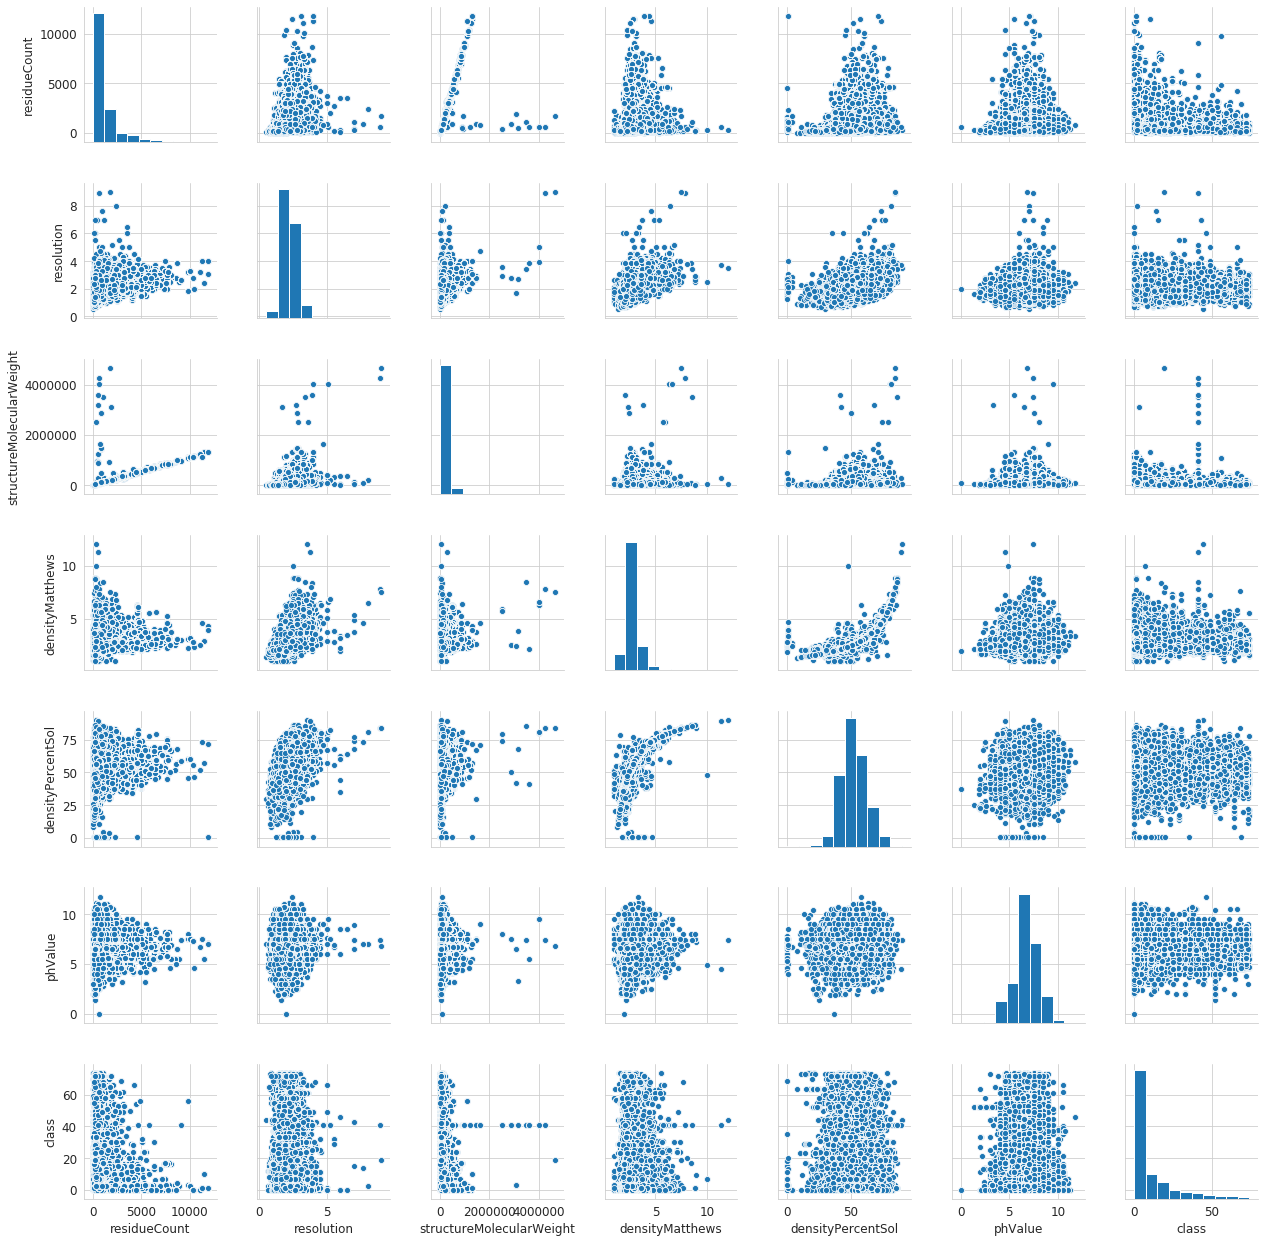

In [21]:
plt.rcParams['font.size'] = 12
sns.pairplot(data)

In [34]:
def set_phlevel(x):
    if x > 7:
        return 'Basic'
    elif x < 7:
        return 'Acidic'
    else:
        return 'Neutral'

data['ph_level'] = data['phValue'].apply(set_phlevel)
ph_level = data.groupby('ph_level')['ph_level'].count()

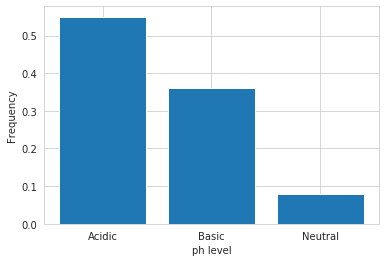

In [40]:
# labels = ph_level.index.tolist()
# sizes = np.round((ph_level.values) * 100 / sum(ph_level.values), 2).tolist()
# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# ax1.axis('equal')  
# plt.tight_layout()
# plt.show()

sizes = np.round((ph_level.values) / sum(ph_level.values), 2).tolist()
plt.bar(x=labels, height=sizes)
plt.xlabel('ph level')
plt.ylabel('Frequency');

In [24]:
data['seq_len'] = data['sequence'].apply(lambda x: len(x))
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue,chainId,sequence,class,ph_level,seq_len
0,101M,oxygen transport,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,3.09,60.2,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,29,Basic,154
2,102M,oxygen transport,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,3.09,60.2,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,29,Basic,154
4,103M,oxygen transport,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,3.09,60.3,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,29,Basic,154
7,104M,oxygen transport,X-RAY DIFFRACTION,Protein,153,1.71,18030.63,1.87,34.3,7.0,A,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,29,Neutral,153
8,105M,oxygen transport,X-RAY DIFFRACTION,Protein,153,2.02,18030.63,1.83,33.0,9.0,A,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,29,Basic,153


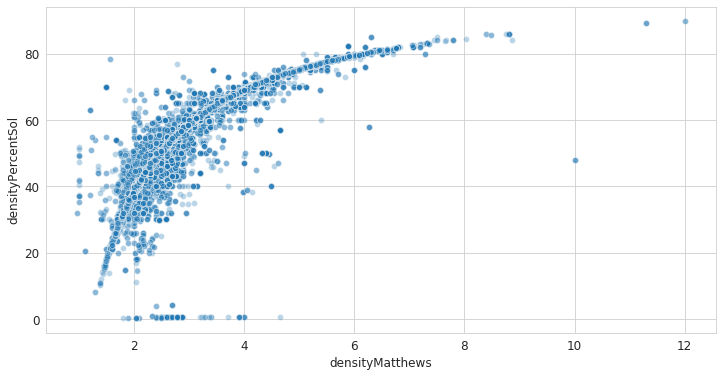

In [26]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='densityMatthews', y='densityPercentSol', data=data, alpha=0.3)

## Building a signle train-test split model

In [20]:
X = data[['residueCount','resolution','structureMolecularWeight','densityMatthews','densityPercentSol','phValue']]
y = data['class']

scaler = StandardScaler().fit(X)
X_norm =  scaler.transform(X)
X_scaled = pd.DataFrame(X_norm, columns=X.columns)
X_scaled.shape

(80659, 6)

In [21]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
scaler = StandardScaler().fit(X_train)
X_train_norm =  scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_norm, columns=X.columns)
X_train_scaled.head()


,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue
0,7.152404,0.324894,6.382702,0.204500,0.488665,-1.061108
1,-0.729687,-1.006610,-0.661070,0.117968,-0.385143,-0.033988
2,-0.166680,-0.340858,-0.160096,-0.559865,-0.496885,0.891268
3,-0.409765,-0.816395,-0.381731,-0.083939,0.170551,0.016943
4,-0.674504,-0.569116,-0.617517,-0.603131,-0.566347,-1.103551


In [23]:
X_test_norm = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_norm, columns=X.columns)
X_test_scaled.head()

,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue
0,3.603927,1.104776,3.119560,1.675542,1.627232,-0.042477
1,5.997053,1.846614,5.177880,0.521784,0.797719,0.636610
2,-0.050726,9.074780,-0.043027,1.415946,1.598038,0.551725
3,-0.182048,0.229787,-0.197343,-0.675241,-0.723391,-0.297135
4,0.239858,0.515109,0.207901,-0.026252,0.128270,0.636610


### Random Forest

In [30]:
#Random Forest with singal train-test split
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1)
m.fit(X_train, y_train)

predictions = m.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy :",accuracy_score(y_test, predictions),'\n')

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      2828
           1       0.81      0.91      0.85      2332
           2       0.89      0.90      0.90      2232
           3       0.95      0.88      0.92       855
           4       0.90      0.91      0.90       659
           5       0.81      0.72      0.77       585
           6       0.90      0.93      0.91       429
           7       0.90      0.83      0.86       423
           8       0.94      0.81      0.87       394
           9       0.85      0.74      0.79       307
          10       0.91      0.71      0.80       264
          11       0.89      0.78      0.83       284
          12       0.76      0.81      0.79       241
          13       0.95      0.77      0.85       256
          14       0.93      0.79      0.85       221
          15       0.90      0.78      0.83       205
          16       0.97      0.82      0.89       199
          17       0.97    

In [35]:
# Random Forest with cross validation and grid search
param_grid = [{'n_estimators':[30, 40], 
               'max_features':[4,6]}]

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1)
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(m, param_grid, cv=kfold)
grid_search.fit(X_train, y_train)

print("Train Accuracy :",grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

predictions = grid_search.predict(X_test)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')

Train Accuracy : 0.8506051730283447
{'max_features': 4, 'n_estimators': 40}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Test Accuracy : 0.8646788990825688 



### Decision Tree

In [34]:
# Decision tree with singal train-test split
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

predictions = dtree.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy :",accuracy_score(y_test, predictions),'\n')

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2828
           1       0.91      0.89      0.90      2332
           2       0.94      0.90      0.92      2232
           3       0.92      0.91      0.91       855
           4       0.93      0.93      0.93       659
           5       0.80      0.81      0.81       585
           6       0.89      0.93      0.91       429
           7       0.85      0.90      0.87       423
           8       0.91      0.88      0.89       394
           9       0.79      0.83      0.81       307
          10       0.79      0.81      0.80       264
          11       0.82      0.82      0.82       284
          12       0.82      0.80      0.81       241
          13       0.87      0.81      0.84       256
          14       0.94      0.85      0.89       221
          15       0.88      0.84      0.86       205
          16       0.86      0.87      0.87       199
          17       0.81    

In [36]:
#Decision Tree with cross validation and grid search
param_grid = [{'max_depth':[5,10],
              'min_samples_leaf':[1, 5, 10]}]

dtree = DecisionTreeClassifier()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(dtree, param_grid, cv=kfold)
grid_search.fit(X_train, y_train)
print("Train Accuracy :",grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

predictions = grid_search.predict(X_test)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')

Train Accuracy : 0.33275992995180315
{'max_depth': 10, 'min_samples_leaf': 1}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Test Accuracy : 0.33951152987850236 



### Gradient Boosting

In [44]:
xgboost = GradientBoostingClassifier(n_estimators=40, learning_rate=0.01, max_depth=3)
xgboost.fit(X_train, y_train)
predictions = xgboost.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy :",accuracy_score(y_test, predictions),'\n')

              precision    recall  f1-score   support

           0       0.20      0.93      0.32      2828
           1       0.85      0.12      0.21      2332
           2       0.44      0.31      0.36      2232
           3       0.61      0.06      0.10       855
           4       0.93      0.06      0.11       659
           5       0.89      0.01      0.03       585
           6       0.80      0.02      0.04       429
           7       0.54      0.02      0.03       423
           8       0.00      0.00      0.00       394
           9       1.00      0.02      0.04       307
          10       0.86      0.09      0.17       264
          11       0.69      0.12      0.21       284
          12       1.00      0.02      0.05       241
          13       0.88      0.03      0.05       256
          14       0.00      0.00      0.00       221
          15       0.76      0.11      0.19       205
          16       1.00      0.14      0.25       199
          17       0.36    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
#Gradient Boosting
parameters = {
    "learning_rate": [0.075, 0.1, 0.15,],
    "max_depth":[5,8],
    "n_estimators":[30, 40],
    }
# "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
# "validation_fraction":[0.1, 0.20, 0.50]

xgboost = GradientBoostingClassifier(n_estimators=40, learning_rate=0.01, max_depth=1)
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = RandomizedSearchCV(xgboost, parameters, cv=kfold)
grid_search.fit(X_train, y_train)

print("Train Accuracy :",grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

predictions = grid_search.predict(X_test)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')

KeyboardInterrupt: 

### Gaussian Naive Bayes

In [36]:

m = GaussianNB()
m.fit(X_train, y_train)
predictions = m.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy :",accuracy_score(y_test, predictions),'\n')

              precision    recall  f1-score   support

           0       0.19      0.01      0.01      2828
           1       0.18      0.31      0.22      2332
           2       0.31      0.25      0.28      2232
           3       0.19      0.04      0.07       855
           4       0.00      0.00      0.00       659
           5       0.04      0.32      0.08       585
           6       0.00      0.00      0.00       429
           7       0.00      0.00      0.00       423
           8       0.00      0.00      0.00       394
           9       0.03      0.17      0.05       307
          10       0.00      0.00      0.00       264
          11       0.00      0.00      0.00       284
          12       0.00      0.00      0.00       241
          13       0.00      0.00      0.00       256
          14       0.00      0.00      0.00       221
          15       0.00      0.00      0.00       205
          16       0.00      0.00      0.00       199
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
nb = GaussianNB()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(nb, X_train, y_train, cv=kfold)

print(scores)
print(scores.mean())



[0.10196808 0.09669921 0.10289788 0.09840384 0.09700914 0.10227801
 0.09979854 0.09686919 0.09795412 0.09779913]
0.09916771458922445


### Multinomial Naive Bayes

In [38]:
m = MultinomialNB()
m.fit(X_train, y_train)
predictions = m.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy :",accuracy_score(y_test, predictions),'\n')

              precision    recall  f1-score   support

           0       0.15      0.07      0.09      2828
           1       0.21      0.09      0.13      2332
           2       0.24      0.13      0.17      2232
           3       0.02      0.01      0.02       855
           4       0.09      0.14      0.11       659
           5       0.05      0.10      0.07       585
           6       0.02      0.03      0.02       429
           7       0.00      0.00      0.00       423
           8       0.00      0.00      0.00       394
           9       0.02      0.13      0.04       307
          10       0.00      0.00      0.00       264
          11       0.00      0.00      0.00       284
          12       0.12      0.00      0.01       241
          13       0.00      0.00      0.00       256
          14       0.00      0.00      0.00       221
          15       0.00      0.00      0.00       205
          16       0.02      0.05      0.03       199
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
m = MultinomialNB()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(m, X_train, y_train, cv=kfold)
print(scores)
print(scores.mean())

[0.05919727 0.06090191 0.06136681 0.06260654 0.06059197 0.06105687
 0.06229661 0.06633602 0.05951643 0.05719157]
0.06110619934940894


###  Support Vector Machine

In [44]:
svm = LinearSVC()

svm.fit(X_train_scaled, y_train)

predictions = svm.predict(X_test_scaled)
print(classification_report(y_test, predictions))
print("Accuracy :",accuracy_score(y_test, predictions),'\n')

              precision    recall  f1-score   support

           0       0.18      0.76      0.29      2828
           1       0.16      0.18      0.17      2332
           2       0.25      0.17      0.20      2232
           3       0.00      0.00      0.00       855
           4       0.00      0.00      0.00       659
           5       0.00      0.00      0.00       585
           6       0.00      0.00      0.00       429
           7       0.00      0.00      0.00       423
           8       0.00      0.00      0.00       394
           9       0.00      0.00      0.00       307
          10       0.00      0.00      0.00       264
          11       0.00      0.00      0.00       284
          12       0.00      0.00      0.00       241
          13       0.00      0.00      0.00       256
          14       0.00      0.00      0.00       221
          15       0.00      0.00      0.00       205
          16       0.00      0.00      0.00       199
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# Support Vector Machine
param_grid = [{'C': [1, 10, 100]}, {'dual' : [True, False]}]

svm = LinearSVC()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(svm, param_grid, cv=kfold)
grid_search.fit(X_train_scaled, y_train)

print("Train Accuracy :",grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

predictions = grid_search.predict(X_test_scaled)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### K Nearest Neighbors 

In [40]:
#KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
predictions = knn.predict(X_test_scaled)
print(classification_report(y_test, predictions))
print("Accuracy :",accuracy_score(y_test, predictions),'\n')

              precision    recall  f1-score   support

           0       0.60      0.69      0.64      2828
           1       0.67      0.67      0.67      2332
           2       0.75      0.72      0.74      2232
           3       0.77      0.72      0.75       855
           4       0.72      0.78      0.75       659
           5       0.59      0.56      0.58       585
           6       0.65      0.76      0.70       429
           7       0.61      0.69      0.65       423
           8       0.61      0.58      0.60       394
           9       0.61      0.56      0.58       307
          10       0.64      0.55      0.59       264
          11       0.62      0.57      0.60       284
          12       0.56      0.51      0.54       241
          13       0.75      0.66      0.70       256
          14       0.70      0.66      0.68       221
          15       0.77      0.67      0.72       205
          16       0.83      0.68      0.75       199
          17       0.65    

In [43]:
# K-nearest naighbour with grid search and cross validation
param_grid = [{'n_neighbors':[3, 5, 10, 15], 
               'weights':['uniform','distance']}]
#'metric':['euclidean','manhattan']

knn = KNeighborsClassifier(n_neighbors=3)
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

grid_search = GridSearchCV(knn, param_grid, cv=kfold)
grid_search.fit(X_train_scaled, y_train)

print("Train Accuracy :",grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

predictions = grid_search.predict(X_test_scaled)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')

Train Accuracy : 0.8219969935065942
{'n_neighbors': 15, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')
Test Accuracy : 0.8408132903545747 



### Logistic Regression with OneVsRest Classifier

In [30]:
# Logistic with single train test split
logreg = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial')
mulreg = OneVsRestClassifier(logreg)
mulreg.fit(X_train, y_train)
predictions = mulreg.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy :",accuracy_score(y_test, predictions),'\n')

              precision    recall  f1-score   support

           0       0.17      0.91      0.29      2828
           1       0.00      0.00      0.00      2332
           2       0.20      0.11      0.14      2232
           3       0.00      0.00      0.00       855
           4       0.00      0.00      0.00       659
           5       0.00      0.00      0.00       585
           6       0.00      0.00      0.00       429
           7       0.00      0.00      0.00       423
           8       0.00      0.00      0.00       394
           9       0.00      0.00      0.00       307
          10       0.00      0.00      0.00       264
          11       0.00      0.00      0.00       284
          12       0.00      0.00      0.00       241
          13       0.00      0.00      0.00       256
          14       0.00      0.00      0.00       221
          15       0.00      0.00      0.00       205
          16       0.52      0.06      0.11       199
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
mulreg = OneVsRestClassifier(logreg)
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(mulreg, X_train, y_train, cv=kfold)
print(scores)
print(scores.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

[0.18162095 0.17650705 0.18084612 0.17666202 0.18456532 0.17480242
 0.18084612 0.17622443 0.18133912 0.17622443]
0.17896379649733027
